# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jun18-1529'

In [4]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'

In [8]:
from concord.simulation import (
    Simulation,
    SimConfig,
    TrajectoryConfig,   # ← because state_type == 'trajectory'
    BatchConfig,
)

# ── 1. global simulation settings ──────────────────────────────────
sim_cfg = SimConfig(
    n_cells = 1_000,
    n_genes =   100,
    seed    =    42,
    non_neg =  True,
    to_int  =  True,
)

# ── 2. trajectory (state) settings ─────────────────────────────────
traj_cfg = TrajectoryConfig(
    # generic “state” parameters
    distribution   = "normal",   # ← state_distribution
    level          = 10,         # ← state_level
    min_level      = 0,          # ← state_min_level
    dispersion     = 2.0,        # ← state_dispersion

    # trajectory-specific knobs (copied 1-to-1)
    program_num            = 5,              # trajectory_program_num
    program_structure      = "linear_bidirectional",
    program_on_time_fraction = 0.1,
    cell_block_size_ratio  = 0.6,
    loop_to                = None,
)

# ── 3. batch settings ──────────────────────────────────────────────
batch_cfg = BatchConfig(
    n_batches    = 2,
    effect_type  = "batch_specific_features",    # batch_type
    distribution = "normal",                     # batch_distribution
    level        = [10, 10],                     # batch_level
    dispersion   = [2.0, 2.0],                   # batch_dispersion
    feature_frac = 0.1,                          # matches the old default
    # cell_proportion defaults to [0.5, 0.5] because n_batches = 2
)

# ── 4. run the simulation ──────────────────────────────────────────
sim   = Simulation(sim_cfg, traj_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()

# keep the “counts” layer your downstream code expects
adata.layers["counts"] = adata.X.copy()


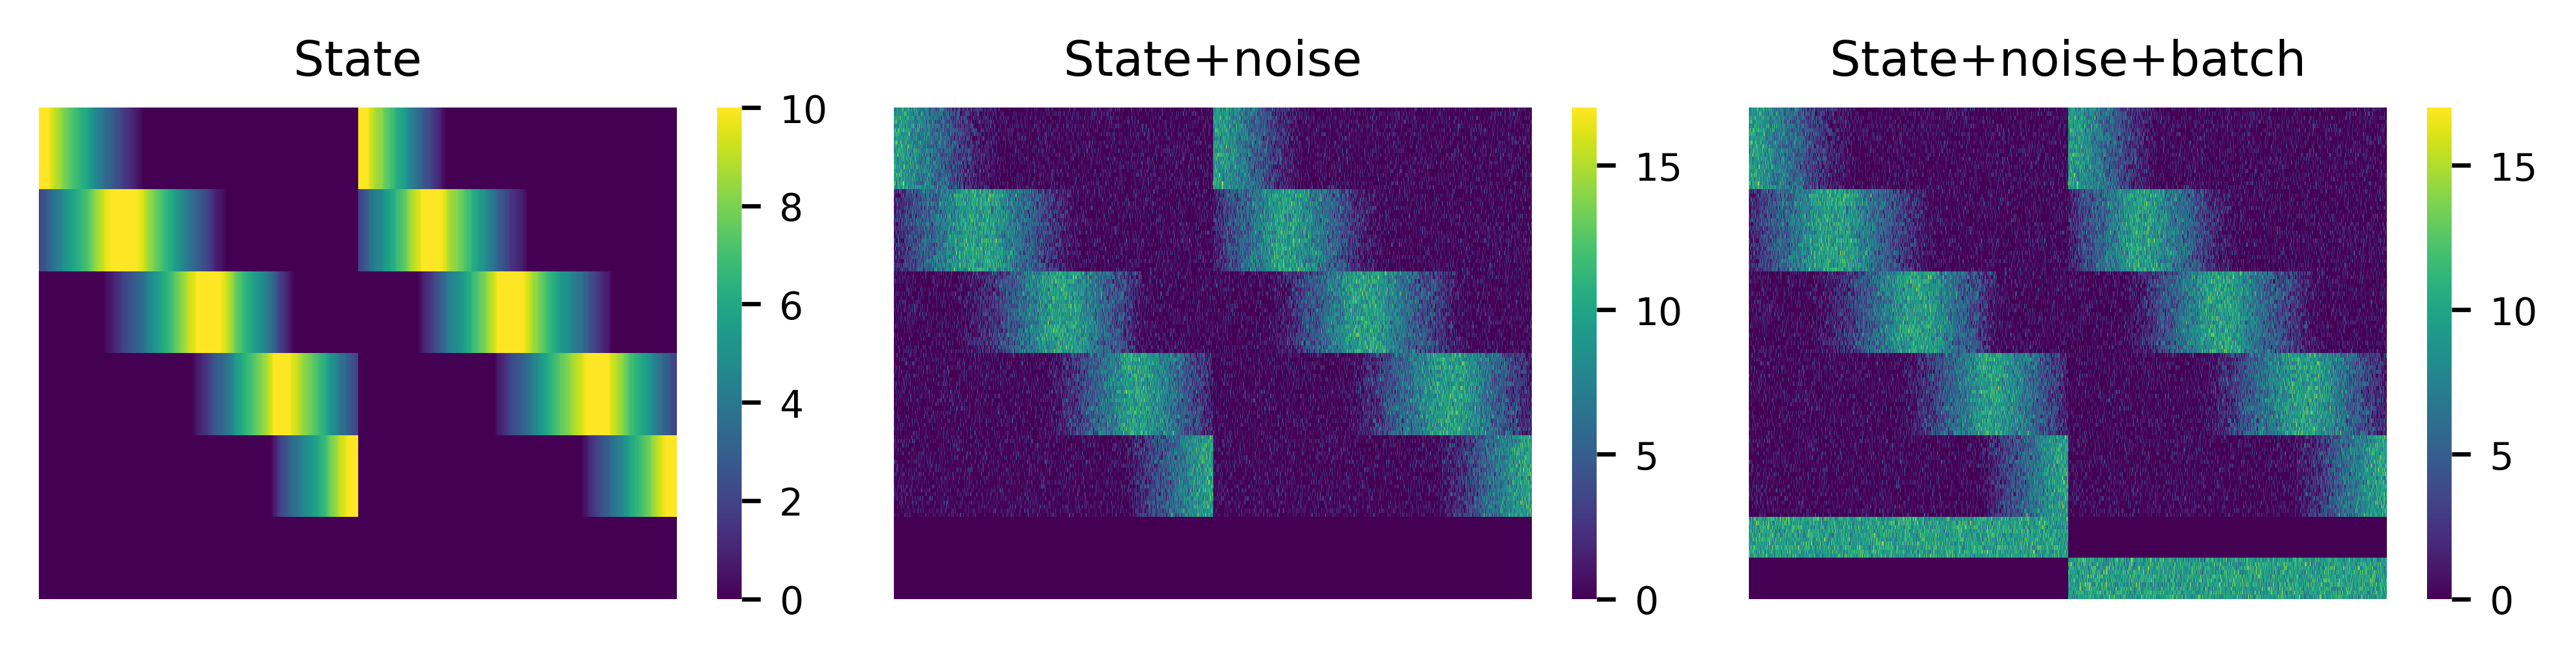

In [48]:
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 3
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"data_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

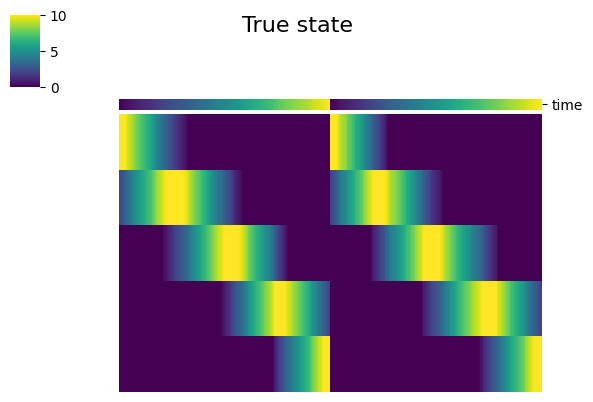

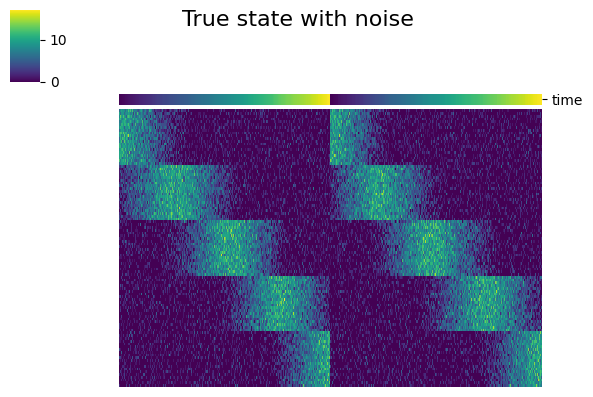

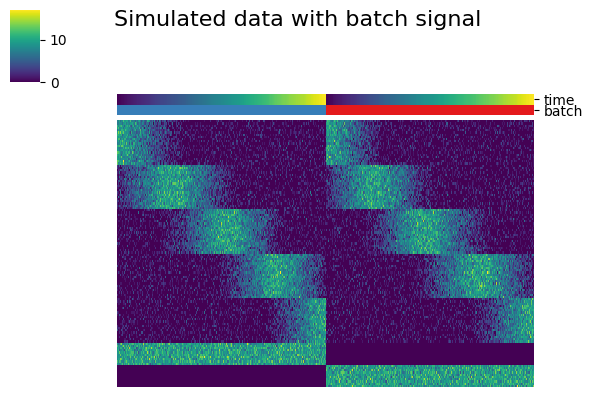

In [9]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### Integration pipeline

In [23]:
combined_keys = [
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", "scanvi",
        "concord", "contrastive"
    ]
latent_dim = 30

In [ ]:

time_log, ram_log, vram_log = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=combined_keys,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=42,                              # Random seed for reproducibility
    compute_umap=True,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
)


Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Epoch 1 Training: 100%|██████████| 14/14 [00:00<00:00, 589.53it/s, loss=3.61]
FAISS not found. Using sklearn for k-NN computation.
Epoch 9 Training: 100%|██████████| 14/14 [00:00<00:00, 602.64it/s, loss=3.52]

Concord - WARNING - save_dir is None. Skipping model/config saving.



concord completed in 0.36 sec.
Running UMAP on concord...
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.


Epoch 1 Training: 100%|██████████| 15/15 [00:00<00:00, 380.02it/s, loss=3.54]
FAISS not found. Using sklearn for k-NN computation.
Epoch 9 Training: 100%|██████████| 15/15 [00:00<00:00, 421.50it/s, loss=3.4]

Concord - WARNING - save_dir is None. Skipping model/config saving.



contrastive completed in 0.49 sec.
Running UMAP on contrastive...
Running UMAP on unintegrated...
scanorama completed in 0.05 sec.
Running UMAP on scanorama...


Found 120 genes among all datasets
[[0.    0.002]
 [0.    0.   ]]


100%|██████████| 30/30 [00:01<00:00, 22.30it/s]
liger completed in 4.91 sec.
Running UMAP on liger...


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).


harmony completed in 0.60 sec.
Running UMAP on harmony...


	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
scvi completed in 19.12 sec.
Running UMAP on scvi...
❌ scanvi failed: Making .obs["time"] categorical failed. Expected categories: ['2' '4' '5' '6' '7' '8' '9' '10' '12' '14' '15' '16' '17' '18' '19' '22'
 '23' '24' '25' '28' '29' '30' '31' '33' '34' '37' '38' '40' '41' '43'
 '44' '47' '48' '49' '50' '54' '56' '57' '58' '59' '60' '61' '62' '64'
 '65' '66' '68' '69' '70' '71' '73' '74' '75' '76' '78' '79' '80' '82'
 '83' '86' '87' '88' '89' '91' '92' '93' '94' '95' '96' '98' '99' '100'
 '101' '102' '103' '104' '106' '107' '108' '109' '111' '112' '113' '114'
 '115' '117' '118' '120' '121' '122' '124' '126' '129' '130' '131' '132'
 '134' '135' '136' '137' '138' '139' '140' '141' '143' '146' '147' '149'
 '151' '153' '154' '155' '158' '159' '160' '164' '167' '168' '169' '170'
 '171' '172' '174' '175' '176' '177' '181' '182' '183' '184' '185' '186'
 '187' '190' '191' '192' '193' '194' '195' '197' '198' '200' '201' '203'
 '204' '206' '208' '209

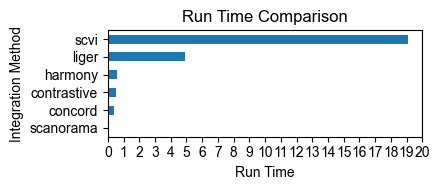

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
# Turn into a DataFrame for easier manipulation
show_keys = [method for method, time_taken in time_log.items() if time_taken is not None]
df = pd.DataFrame.from_dict(time_log, orient='index', columns=['Run Time'])

df = df.loc[show_keys]
# Sort by run time from low to high
df.sort_values(by='Run Time', inplace=True)

with plt.rc_context(rc=custom_rc):
    fig, ax = plt.subplots(figsize=(4.5, 2))

    # Plot horizontal bar chart
    df.plot(kind='barh', legend=False, ax=ax)

    # Label axes
    ax.set_xlabel("Run Time")
    ax.set_ylabel("Integration Method")
    ax.set_title("Run Time Comparison")

    # ------ Key part: set ticks at 1-hour intervals ------
    max_hours = df['Run Time'].max()
    # Create a range from 0 up to the next integer hour
    x_ticks = np.arange(0, int(max_hours) + 2, 1)  # +2 to ensure we cover the top bound
    ax.set_xticks(x_ticks)
    ax.set_xlim([0, int(max_hours)+1])  # Optional: set x-axis limit if desired

    plt.tight_layout()

    # Save and show
    # Replace save_dir / f"integration_methods_run_time_{file_suffix}.pdf" with your actual path
    plt.savefig(save_dir / f"integration_methods_run_time_{file_suffix}.pdf")
    plt.show()

In [30]:
# Add ground truth
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=latent_dim, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=latent_dim, random_state=seed)
# Put the PCA result in the adata object, so only one object is needed
adata.obsm['no_noise'] = adata_state.obsm['PCA_no_noise']
adata.obsm['wt_noise'] = adata_state.obsm['PCA_wt_noise']
ccd.ul.run_umap(adata, source_key='no_noise', result_key='no_noise_UMAP', n_components=2, random_state=seed)
ccd.ul.run_umap(adata, source_key='wt_noise', result_key='wt_noise_UMAP', n_components=2, random_state=seed)
adata.obsm

AxisArrays with keys: X_pca, unintegrated, X_concord_warmup, concord, concord_UMAP, contrastive, contrastive_UMAP, unintegrated_UMAP, scanorama, scanorama_UMAP, liger, liger_UMAP, harmony, harmony_UMAP, scvi, scvi_UMAP, X_draw_graph_kk, no_noise, wt_noise, no_noise_UMAP, wt_noise_UMAP

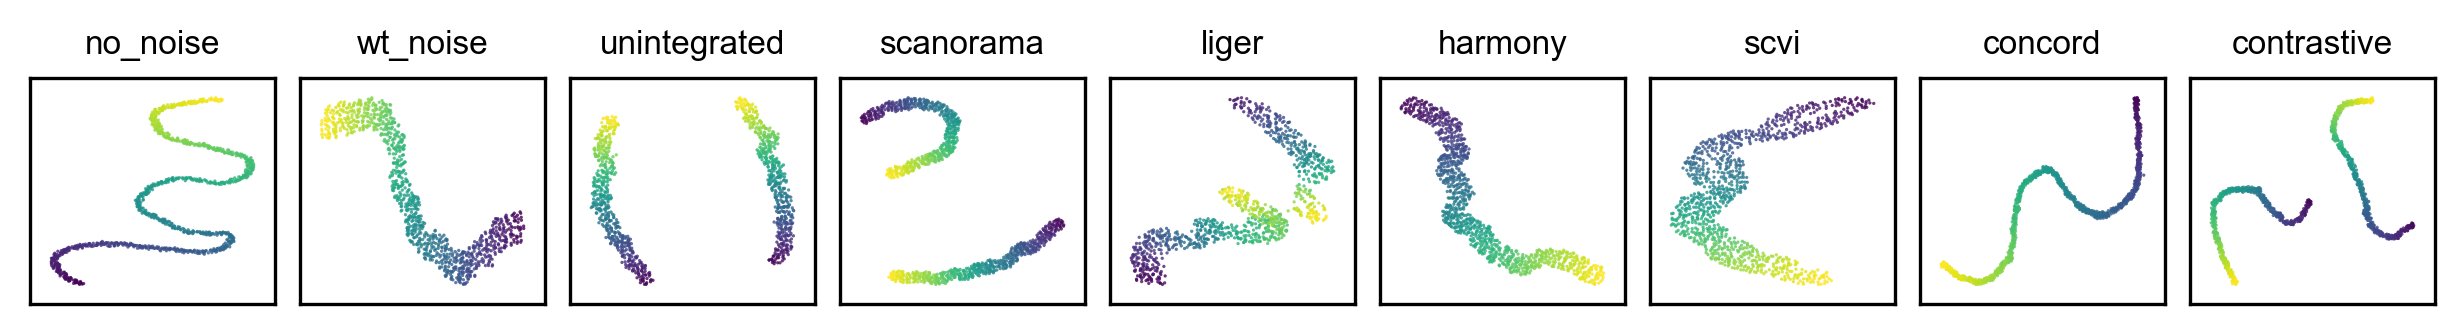

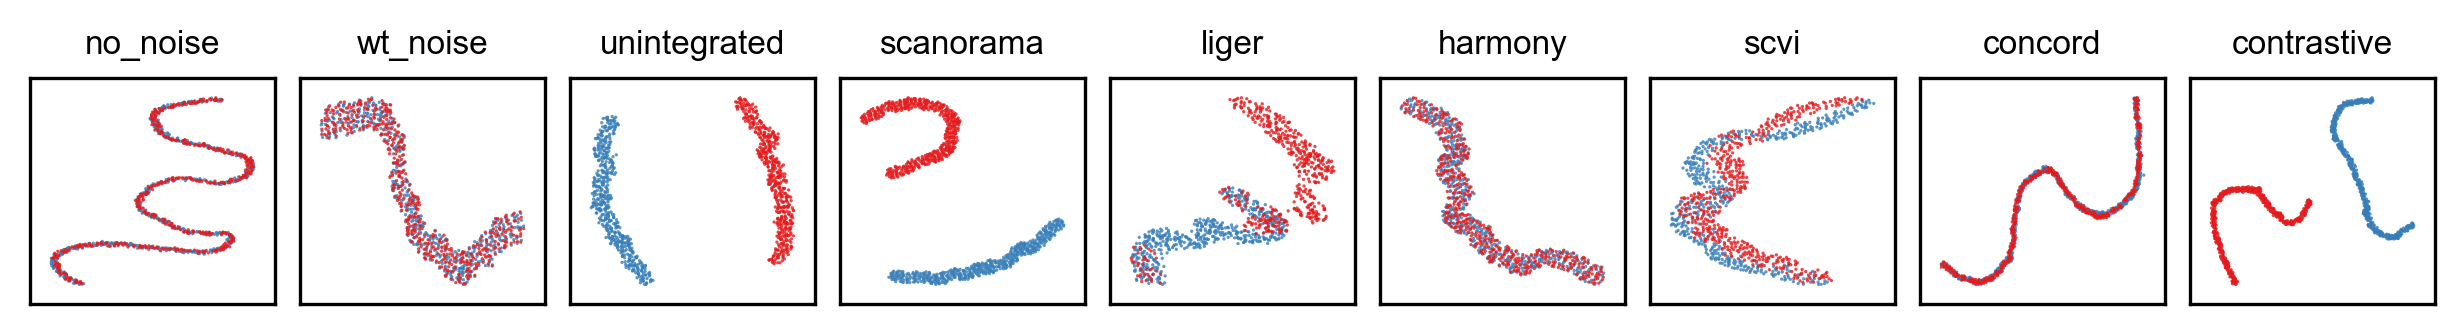

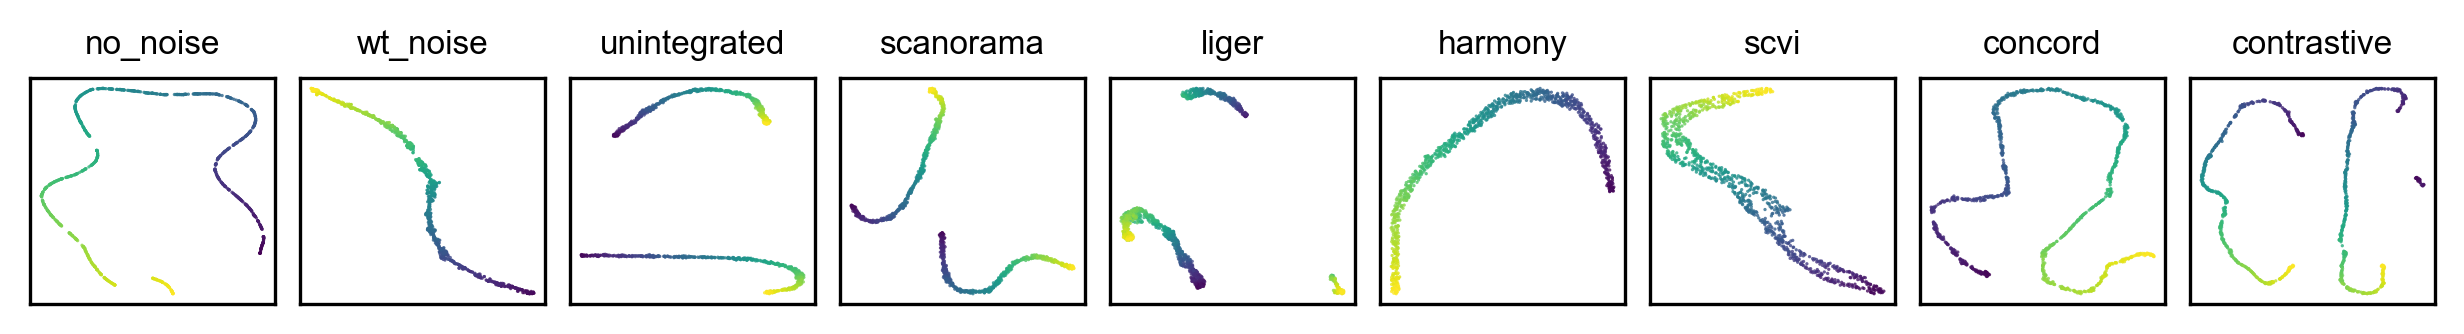

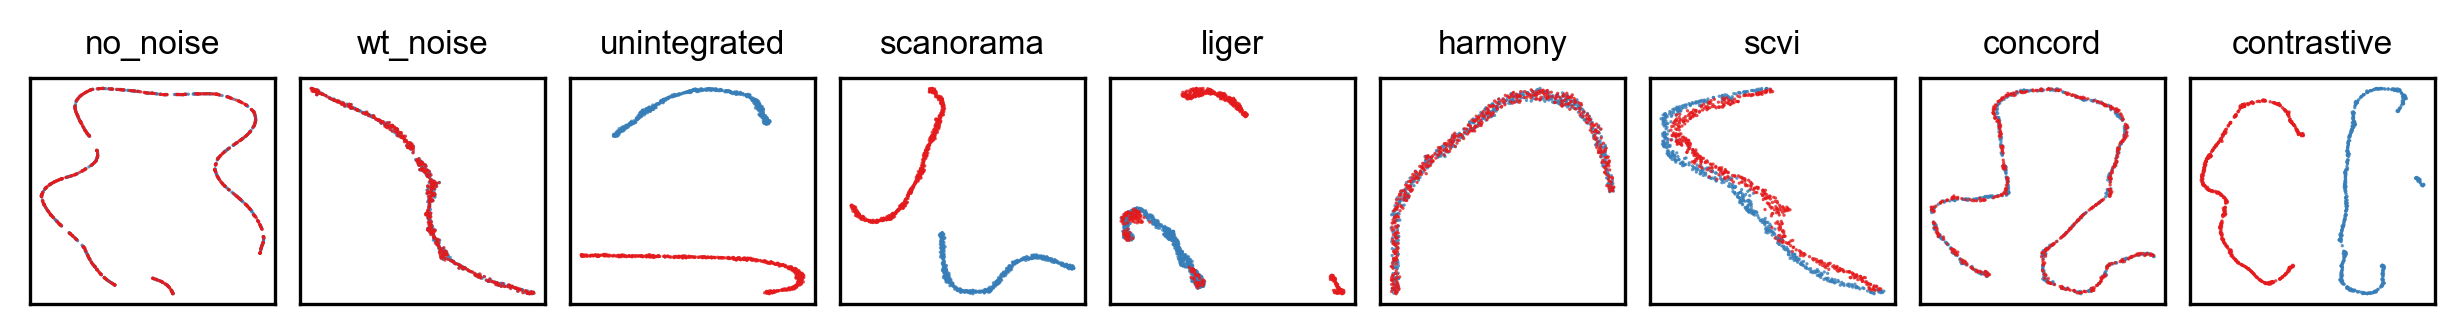

In [31]:
# plot everything
import matplotlib.pyplot as plt

show_keys = ['no_noise', 'wt_noise'] + [key for key in combined_keys if key in adata.obsm.keys()]
# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch']
basis_types = ['KNN', 'UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [33]:
adata.layers['no_noise'] = np.zeros_like(adata.X)
adata.layers['wt_noise'] = np.zeros_like(adata.X)
# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()
adata.layers['wt_noise'][:, adata_indices] = adata_state.layers['wt_noise'][:, adata_state_indices].copy()

# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord', path=batch_indices, sigma=2)
adata.obsm['concord_sorted'] = adata.obsm['concord'][:, feature_order]


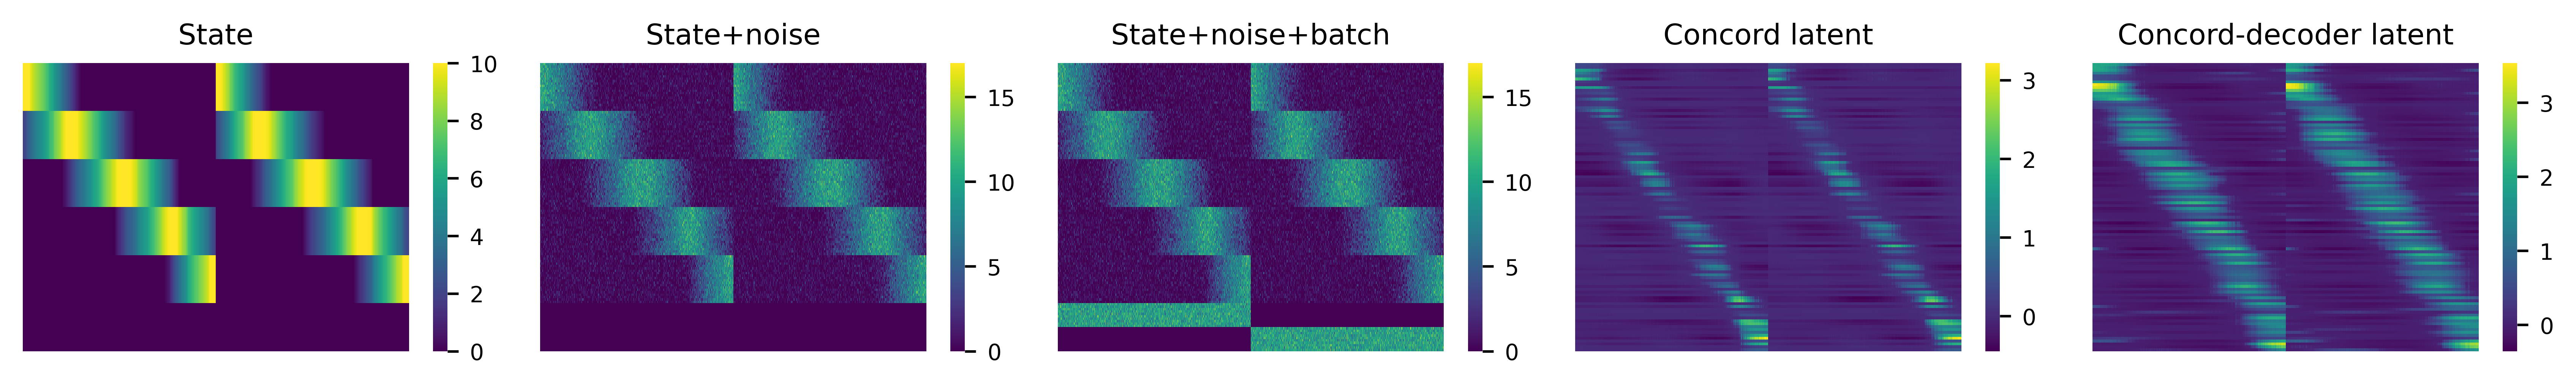

In [54]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord-decoder_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord-decoder latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [36]:
# Save result
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")
print(f"Saved adata_state to {data_dir / f'adata_state_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_trajectory/adata_Jun18-1529.h5ad
Saved adata_state to ../data/simulation_trajectory/adata_state_Jun18-1529.h5ad


# Evaluation

In [37]:
adata = sc.read(data_dir / f"adata_Jun18-1529.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Jun18-1529.h5ad")

### Scib

In [41]:
# Generate Leiden clusters for the clean state data as pseudo labels
leiden_key = 'leiden_no_noise'
sc.pp.neighbors(adata_state, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata_state, resolution=1.0, key_added=leiden_key, random_state=seed)
adata.obs[leiden_key] = adata_state.obs[leiden_key]

In [43]:
from scib_metrics.benchmark import Benchmarker
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
combined_keys = [key for key in combined_keys if key in adata.obsm.keys()]
bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=leiden_key,
    embedding_obsm_keys=combined_keys,
    n_jobs=6,
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
)
bm.benchmark()

Embeddings: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


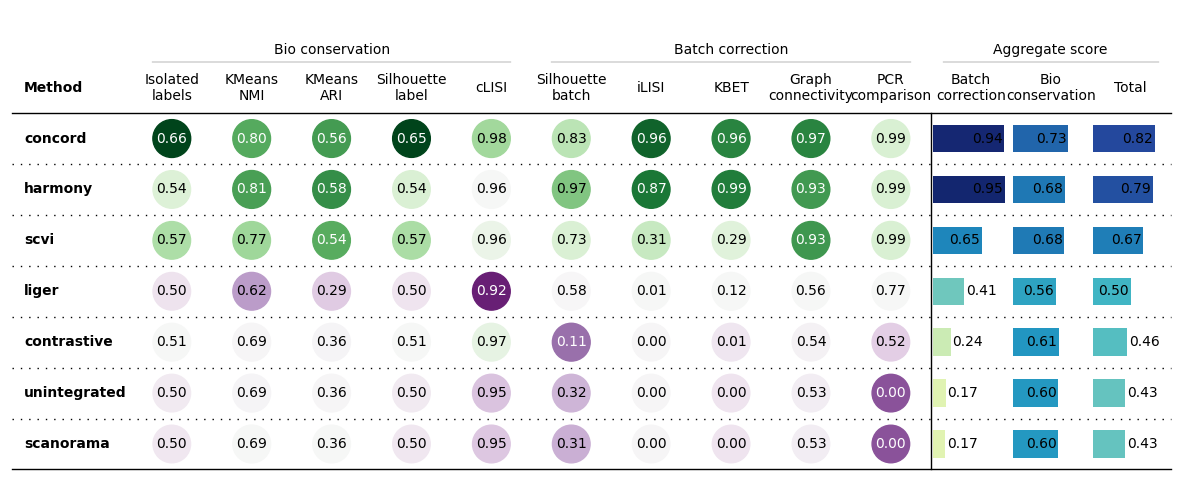

In [44]:
import matplotlib.pyplot as plt
import os
bm.plot_results_table(min_max_scale=False, show=False)
fig = plt.gcf()
fig.set_size_inches(15, 6) 
fig.savefig(os.path.join(save_dir, f'scibmetrics_results_{file_suffix}.pdf'), facecolor='white', dpi=600)
plt.show()
plt.close(fig)

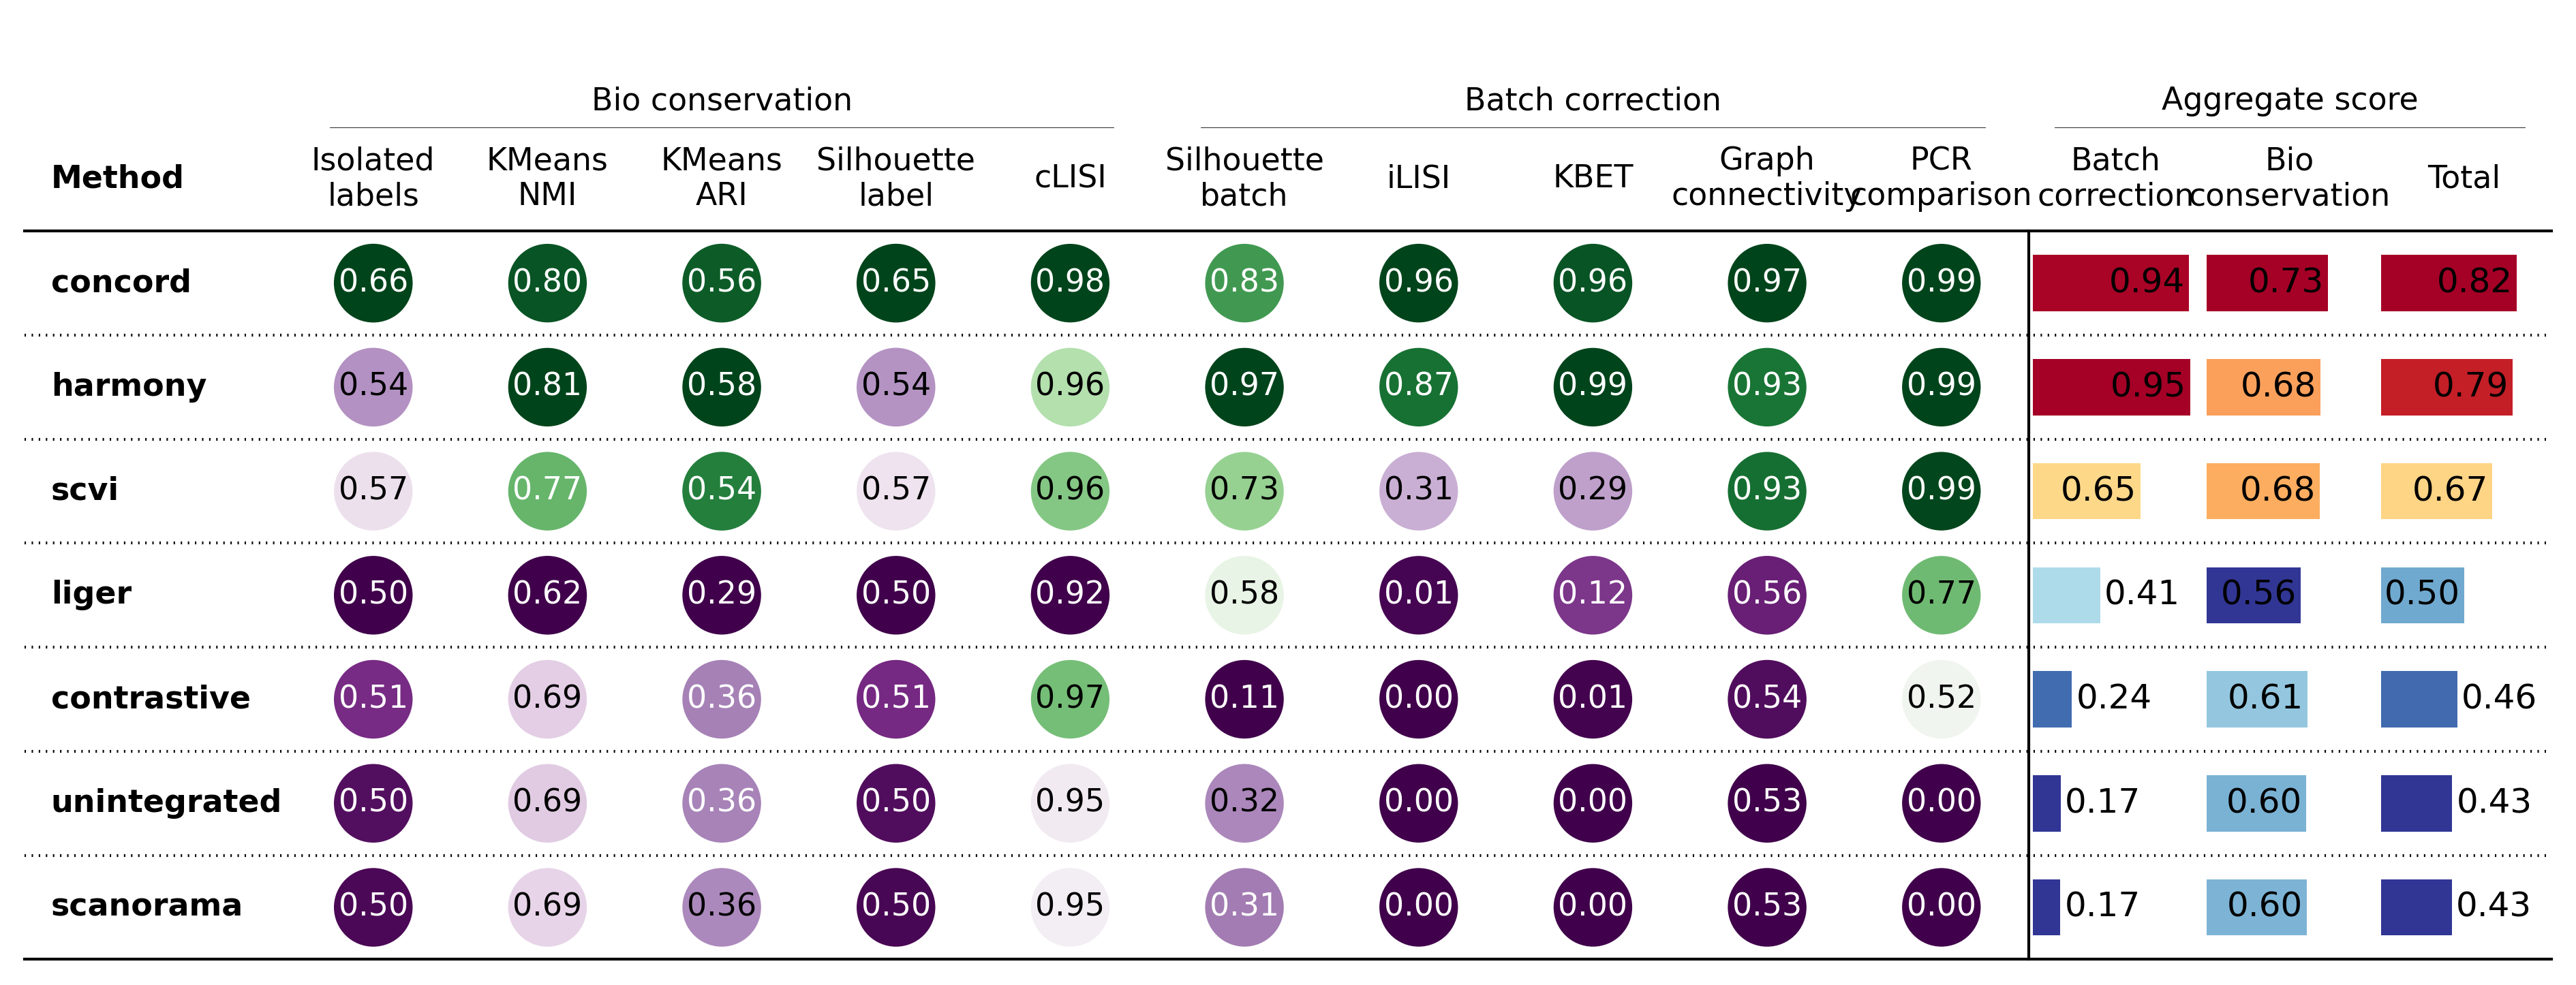

In [45]:
scib_scores = bm.get_results(min_max_scale=False)
# Convert row 'Metric Type' to multi-index column, first level is 'Metric Type', second level is existing column name
metric_type = scib_scores.loc['Metric Type']
scib_scores = scib_scores.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
scib_scores.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in scib_scores.columns])
scib_scores = ccd.bm.benchmark_stats_to_score(scib_scores, min_max_scale=False, one_minus=False, aggregate_score=False, rank=True, rank_col=('Aggregate score', 'Total'), name_exact=False)

ccd.pl.plot_benchmark_table(scib_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', save_path=save_dir / f"scib_results_{file_suffix}.pdf", figsize=(16, 6), dpi=300)

### Topology

Run topological analysis pipeline:

In [47]:
homology_dimensions = [0,1,2]
diagrams = {}
#for key in combined_keys:
for key in combined_keys:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.bm.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

print(f"Saved topology diagrams to {save_dir / f'topology_diagrams_{file_suffix}.pkl'}")

Computing persistent homology for unintegrated
Computing persistent homology for scanorama
Computing persistent homology for liger
Computing persistent homology for harmony
Computing persistent homology for scvi
Computing persistent homology for concord
Computing persistent homology for contrastive


In [50]:
import pickle
with open('../save/dev_simulation_trajectory-Jun18/topology_diagrams_Jun18-1529.pkl', 'rb') as f:
    diagrams = pickle.load(f)

In [54]:
topology_results

{'betti_stats': Dimension        Dim 0                                      Dim 1         \
 Statistic      Entropy    Mean Median Mode     Variance   Entropy   Mean   
 Method                                                                     
 concord       1.823823   42.99    0.0  0.0   32696.1699  2.260308   1.13   
 contrastive   1.804362   37.29    1.0  1.0   27443.0259  3.407532   0.85   
 harmony       3.250854  207.39    0.0  0.0  131271.2579  2.139169   7.72   
 liger         3.559444  295.11    4.0  0.0  178996.0179  3.296095  16.21   
 scanorama     3.234084  224.46    1.0  1.0  158756.6484  2.566127   7.52   
 scvi          2.396824   84.38    0.0  0.0   64467.7756  2.488651   5.30   
 unintegrated  3.336646  251.10    1.0  1.0  172070.0900  2.517481   7.95   
 
 Dimension                               Dim 2                             
 Statistic    Median Mode   Variance   Entropy  Mean Median Mode Variance  
 Method                                                      

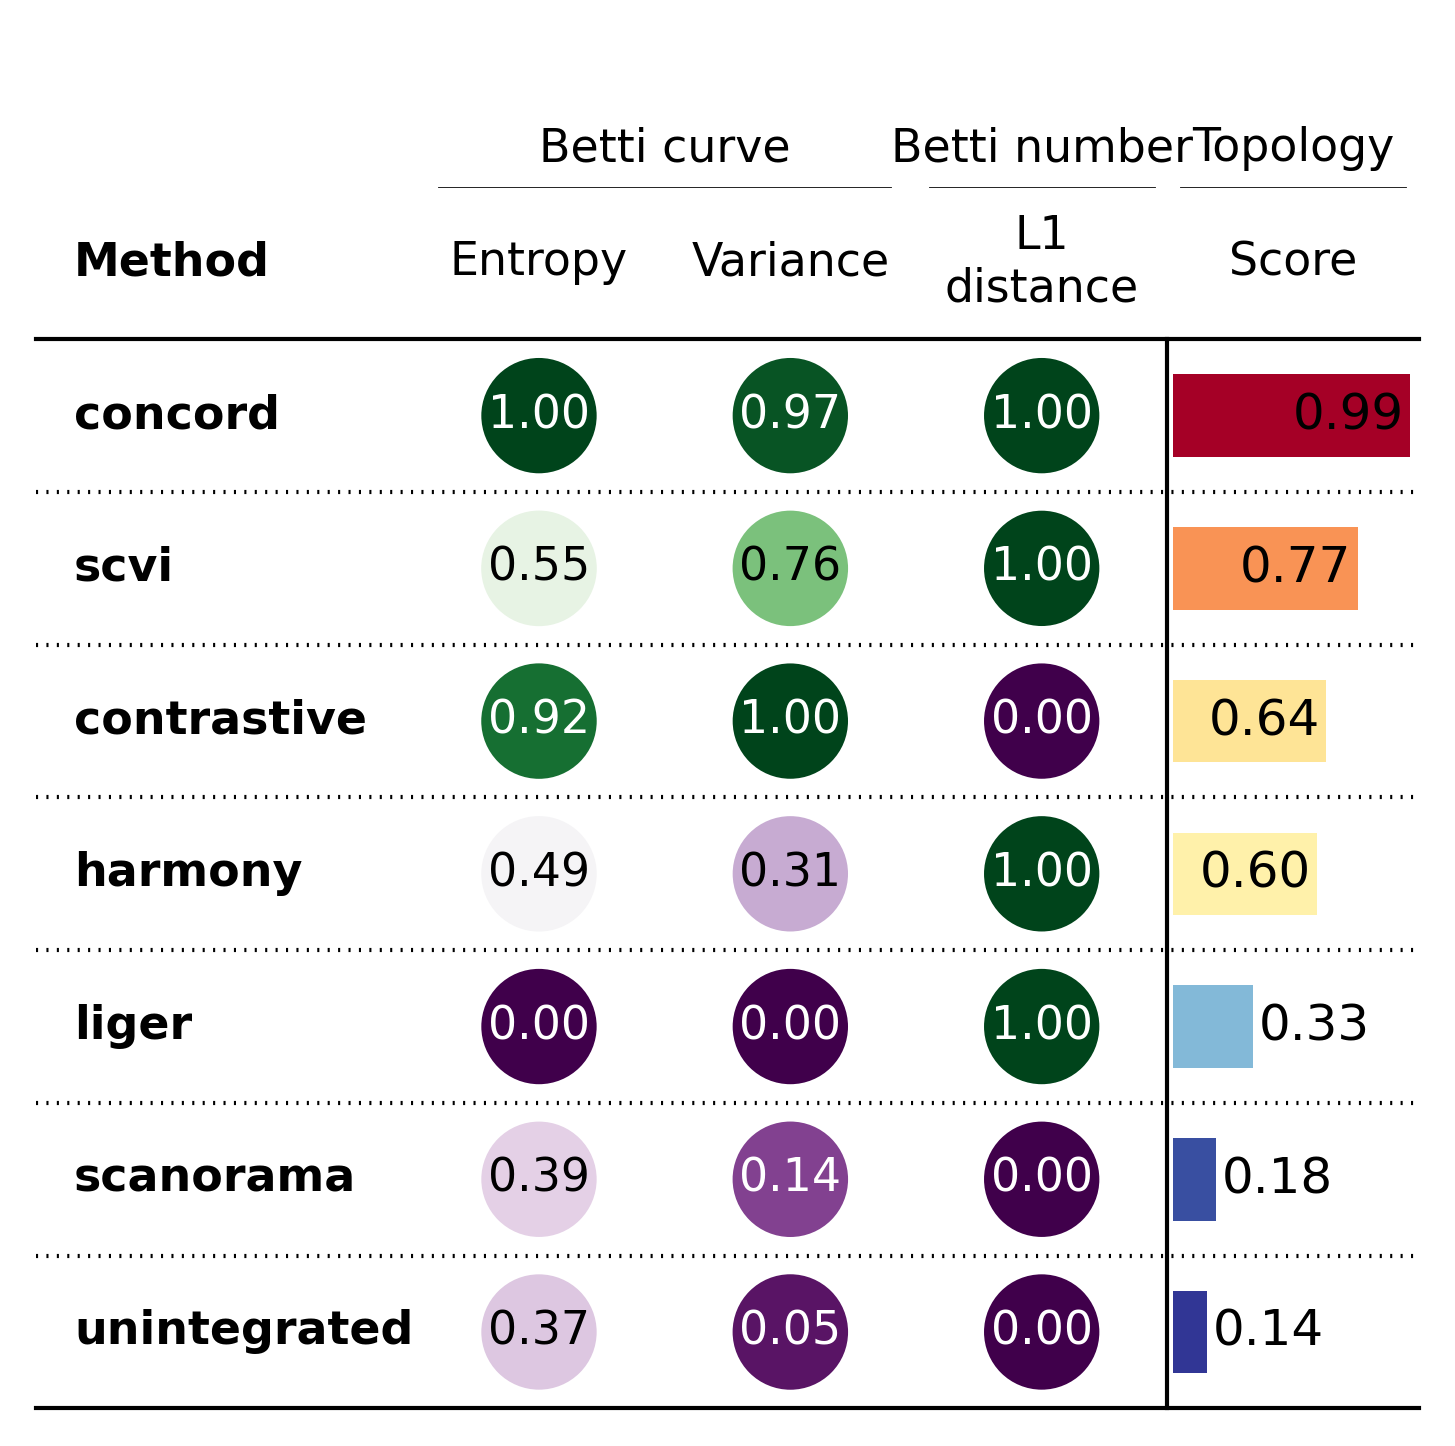

In [56]:
topology_results = ccd.bm.benchmark_topology(diagrams, expected_betti_numbers=[0,0,0], save_dir=save_dir, file_suffix=file_suffix)
max_betti = 5
topology_metrics = topology_results['combined_metrics']
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=5)
agg_name1 = 'Topology'
agg_name2 = 'Score'
topology_scores = ccd.bm.benchmark_stats_to_score(topology_metrics, min_max_scale=True, one_minus=True, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 6), dpi=300)

In [60]:
diagrams_ordered.keys()

dict_keys(['unintegrated', 'scanorama', 'liger', 'harmony', 'scvi', 'concord', 'contrastive'])

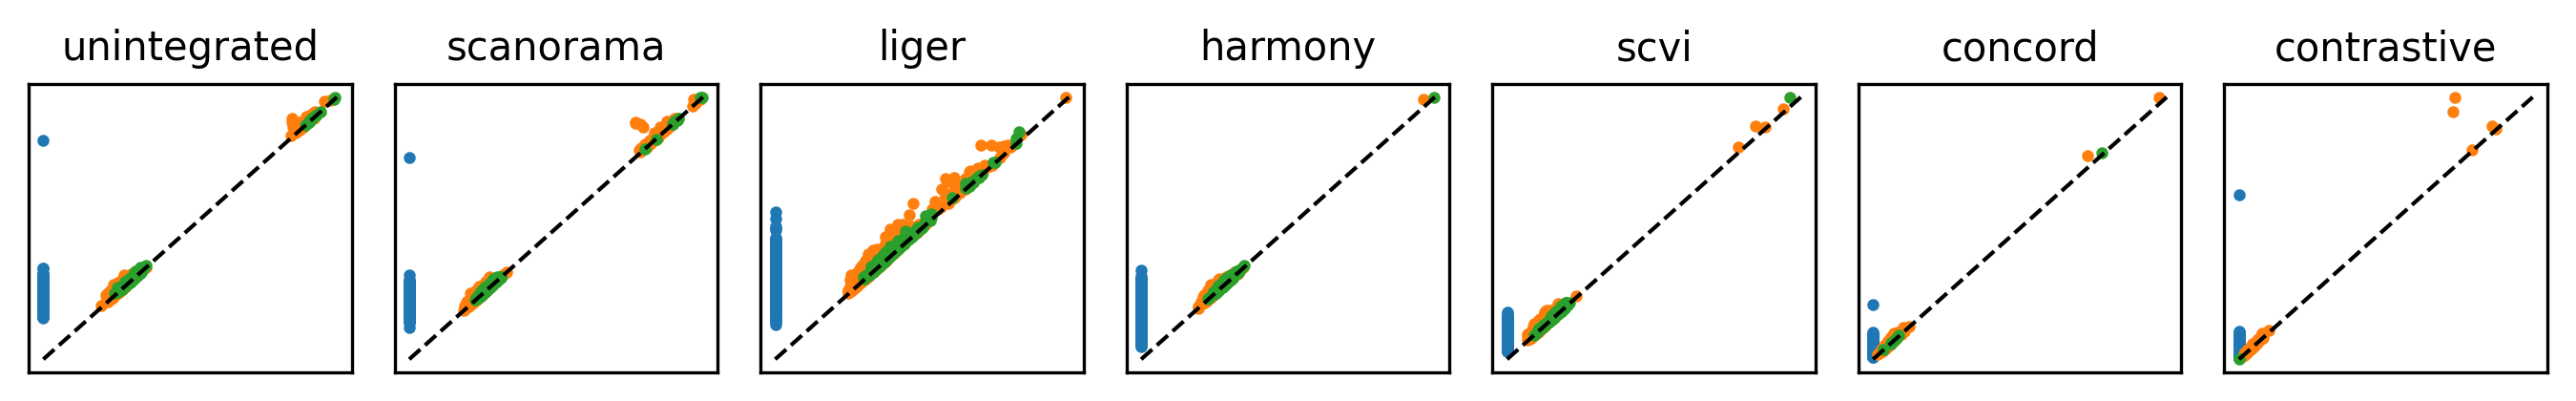

In [61]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

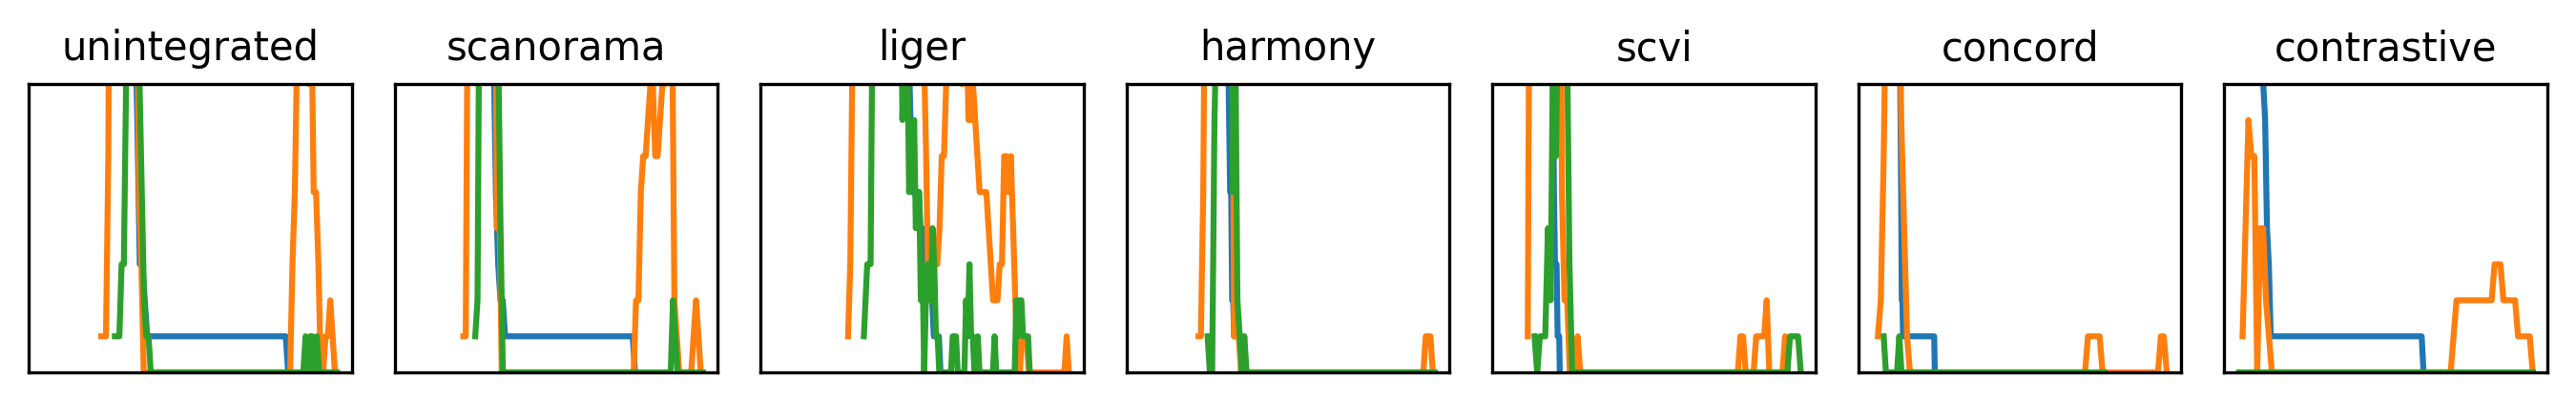

In [62]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

# Geomtric Features 

### Integrated benchmark pipeline

In [72]:
geometry_metrics = ['cell_distance_corr', 'trustworthiness', 'state_dispersion_corr', 'state_batch_distance_ratio']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
#groundtruth_key = 'PCA_wt_noise'
groundtruth_key = 'no_noise'
bm_keys = ['no_noise', 'wt_noise'] + combined_keys
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.bm.benchmark_geometry(
    adata, 
    keys=bm_keys, 
    eval_metrics=geometry_metrics, 
    dist_metric=dist_metric,
    corr_types = corr_types,
    groundtruth_key = groundtruth_key,
    state_key = leiden_key,
    batch_key = batch_key,
    #groundtruth_dispersion = groundtruth_dispersion,
    dispersion_metric='var',
    return_type='full',
    start_point=0,
    end_point=adata.n_obs-1,
    pseudotime_k = 30,
    truetime_key = 'time',
    save_dir=save_dir, 
    file_suffix=file_suffix)

INFO:concord.benchmarking.benchmark:Computing cell distance correlation
INFO:concord.benchmarking.benchmark:Computing trustworthiness
INFO:concord.benchmarking.benchmark:Computing state dispersion correlation
INFO:concord.benchmarking.benchmark:Computing state-batch distance ratio


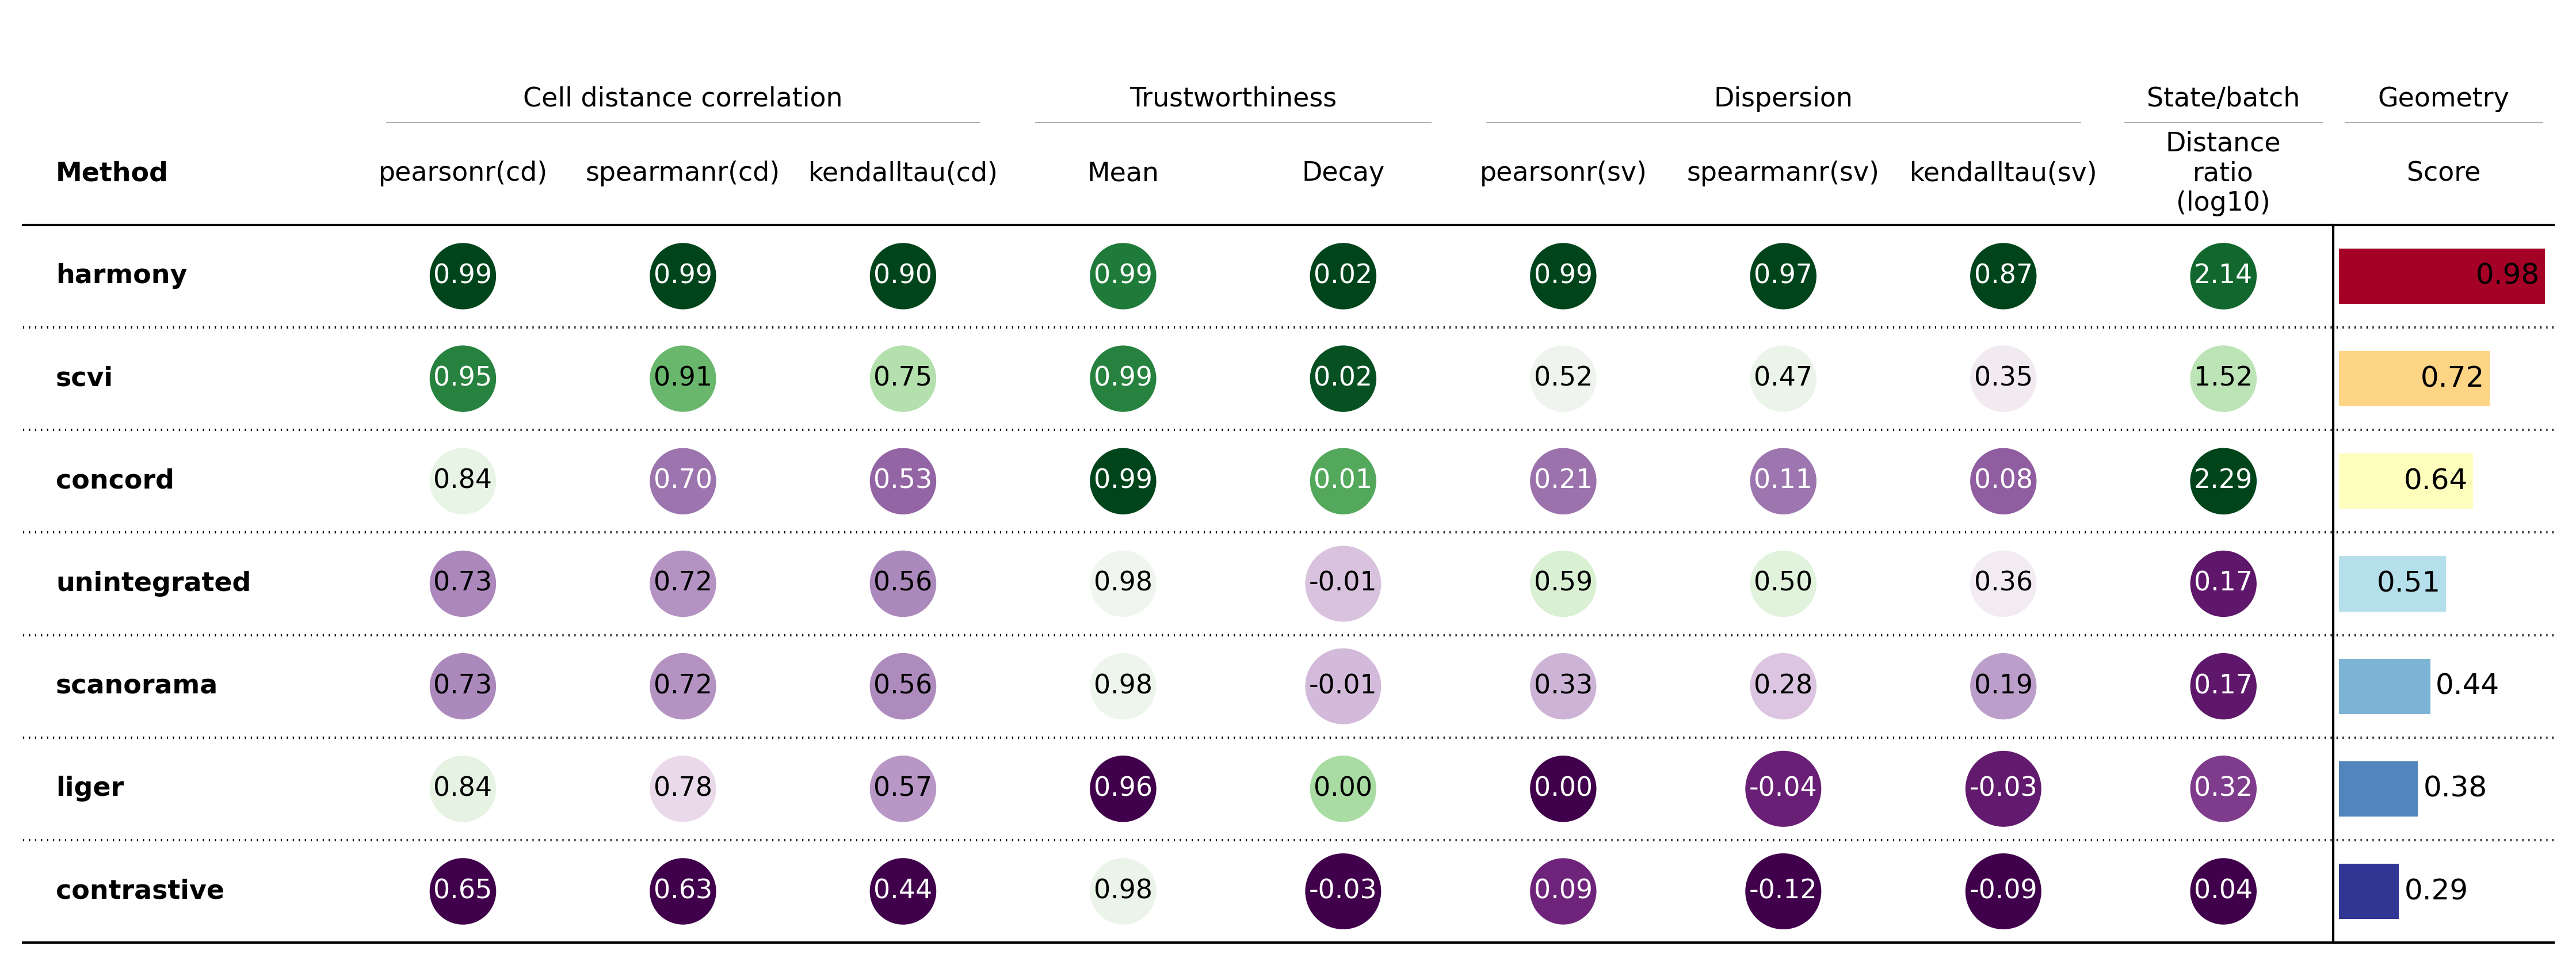

In [73]:
agg_name1 = 'Geometry'
agg_name2 = 'Score'
geometry_scores = ccd.bm.benchmark_stats_to_score(
    geometry_df.drop(index=['no_noise', 'wt_noise']), fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(19, 7), dpi=300)

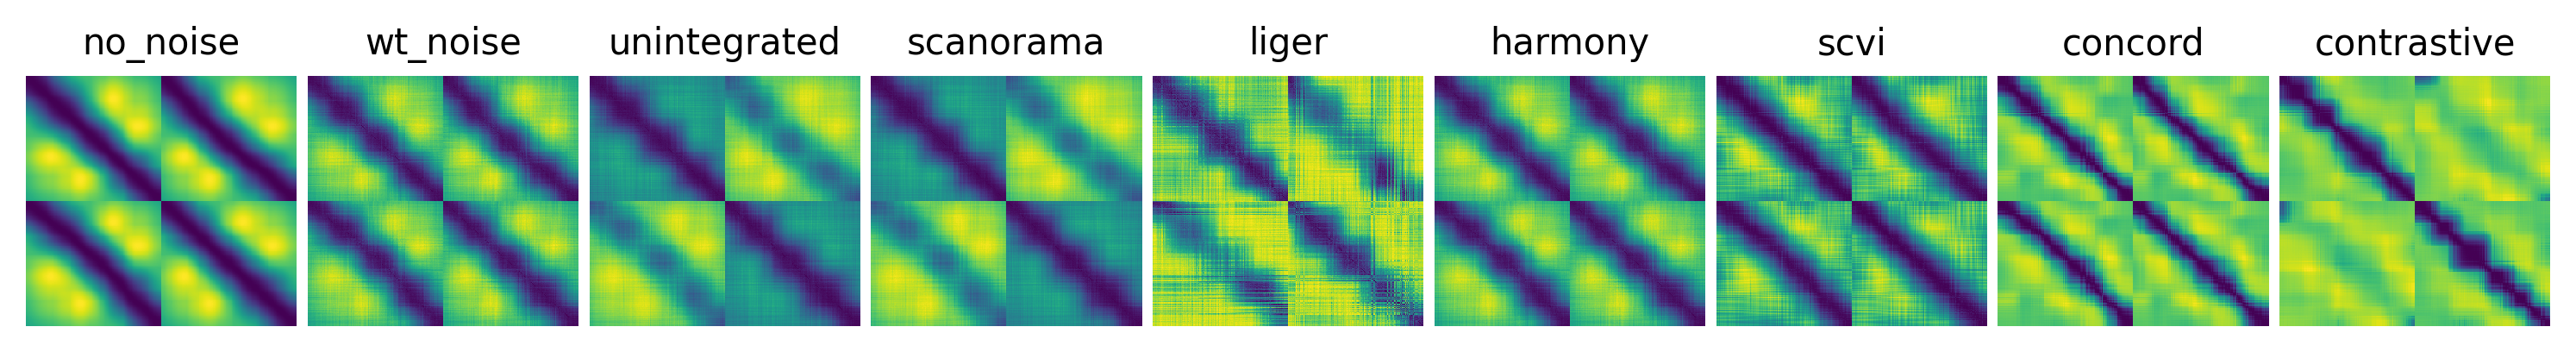

In [76]:
ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = len(geometry_full['cell_distance_corr']['distance']), figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.pdf")

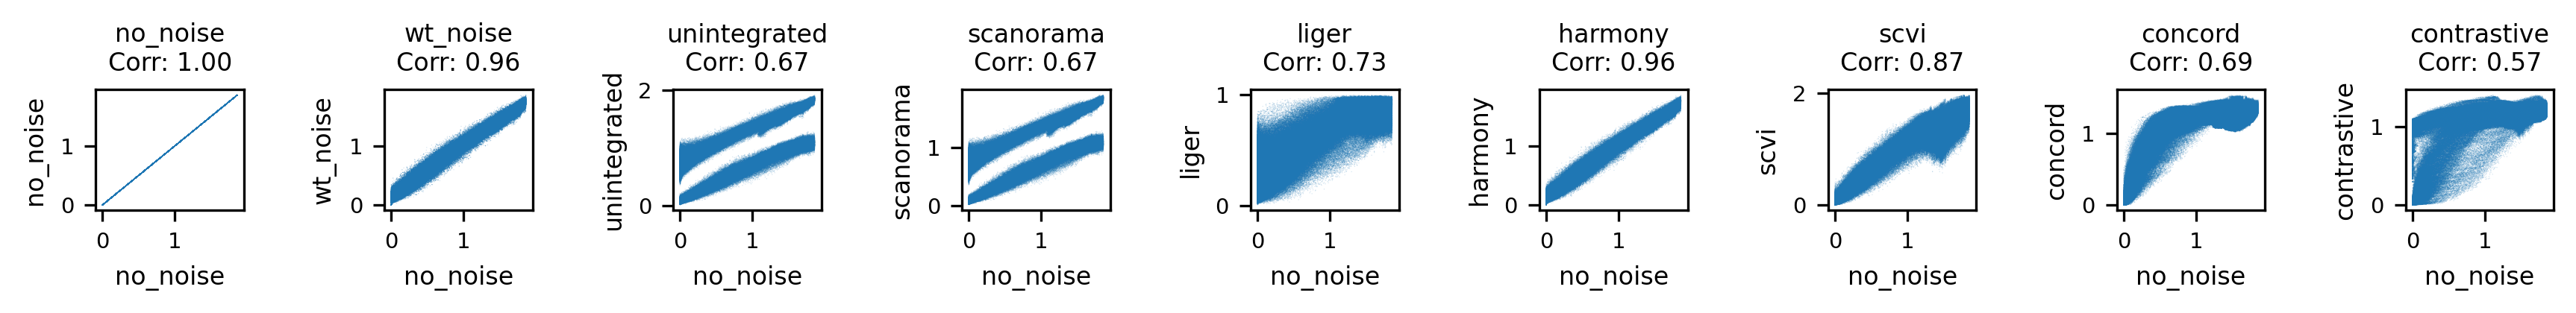

In [80]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['cell_distance_corr']['distance'], 
    correlation= geometry_full['cell_distance_corr']['correlation'],
    ground_key = groundtruth_key,
    s=0.1, alpha = 0.2,
    n_cols = len(geometry_full['cell_distance_corr']['distance']), figsize=(1.3,1.5), dpi=300, save_path=save_dir / f"cell_distance_scatter_{file_suffix}.png")

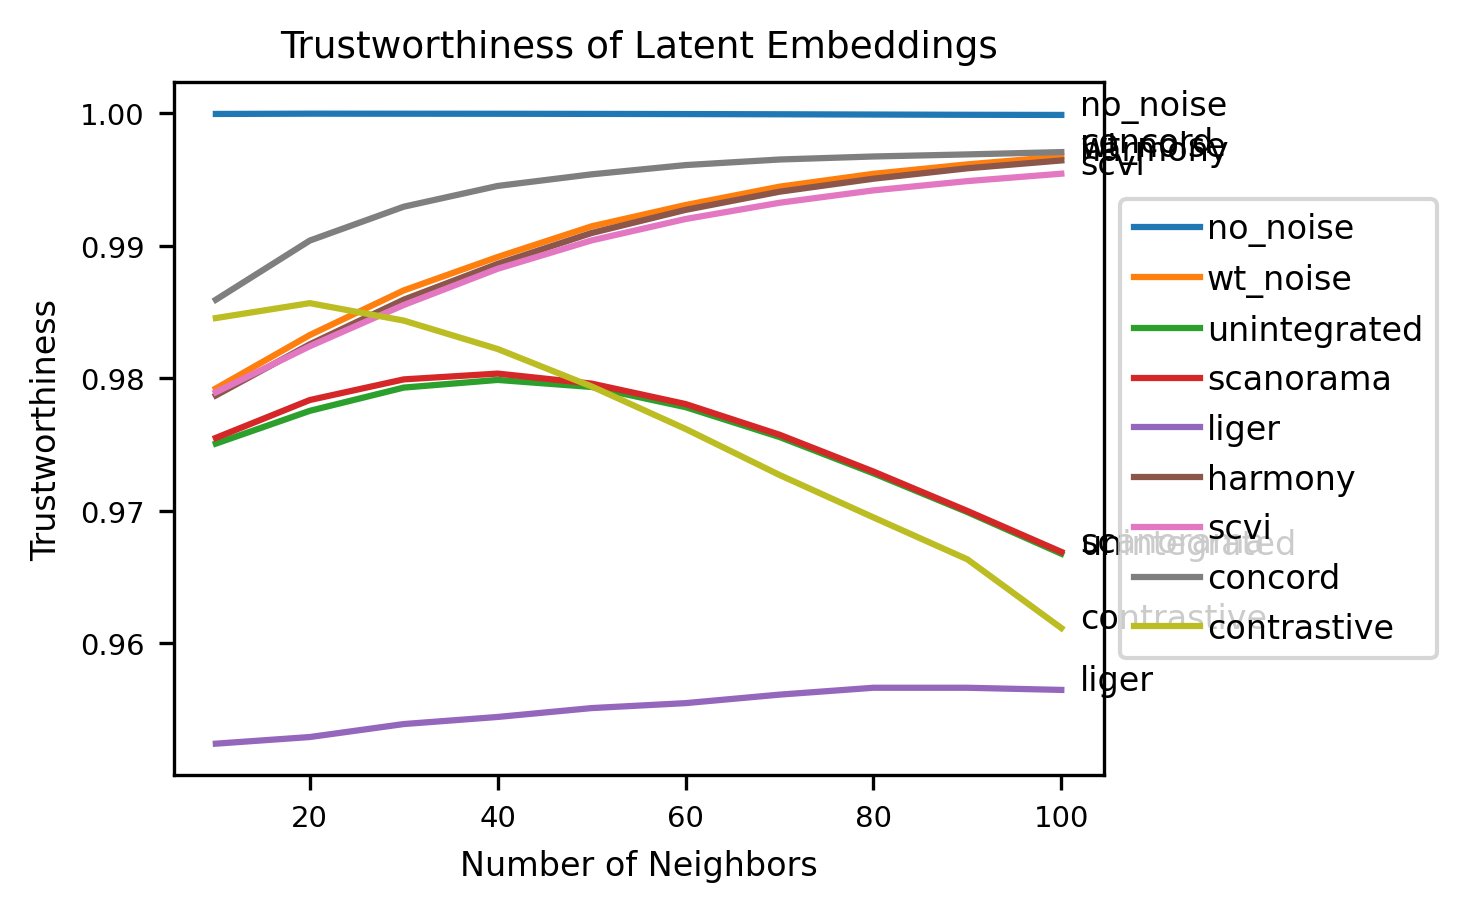

In [81]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=True, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))